In [14]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas import datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy as sp
from scipy import stats
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


In [28]:
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''
plt.rc('font', family='NanumBarunGothic') 

data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                    encoding = 'UTF-8')
data1

,Unnamed: 0,date,add,ca,avg_ta,sum_rn,new_wd,new_ws
0,1,2012-01-01,서울,5.1,-2.7,0.0,-606.6210,-9.6589
1,2,2012-01-02,서울,2.9,-4.6,0.0,-501.4768,-5.1131
2,3,2012-01-03,서울,7.5,-4.3,0.0,-607.3124,-7.7681
3,4,2012-01-04,서울,1.1,-6.8,0.0,-613.9938,-7.9552
4,5,2012-01-05,서울,0.0,-5.2,0.0,-581.0362,-5.4605
...,...,...,...,...,...,...,...,...
3952,3953,2022-10-27,서울,1.4,13.1,0.0,-535.2946,-5.5603
3953,3954,2022-10-28,서울,1.5,13.2,0.0,-284.1164,-4.6625
3954,3955,2022-10-29,서울,1.1,14.1,0.0,-165.0994,-4.6590
3955,3956,2022-10-30,서울,1.1,14.2,0.0,-184.9884,-4.7077


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3957 non-null   int64  
 1   date        3957 non-null   object 
 2   add         3957 non-null   object 
 3   ca          3957 non-null   float64
 4   avg_ta      3957 non-null   float64
 5   sum_rn      3957 non-null   float64
 6   new_wd      3957 non-null   float64
 7   new_ws      3957 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 247.4+ KB


In [29]:
data1['date'] = pd.to_datetime(data1['date'])
data1 = data1[['date', 'new_wd']]

In [30]:
train = data1.loc[data1.date <= '2021-12-31',:]
test = data1.loc[data1.date > '2021-12-31',:]
print(train.shape, test.shape)

(3653, 2) (304, 2)


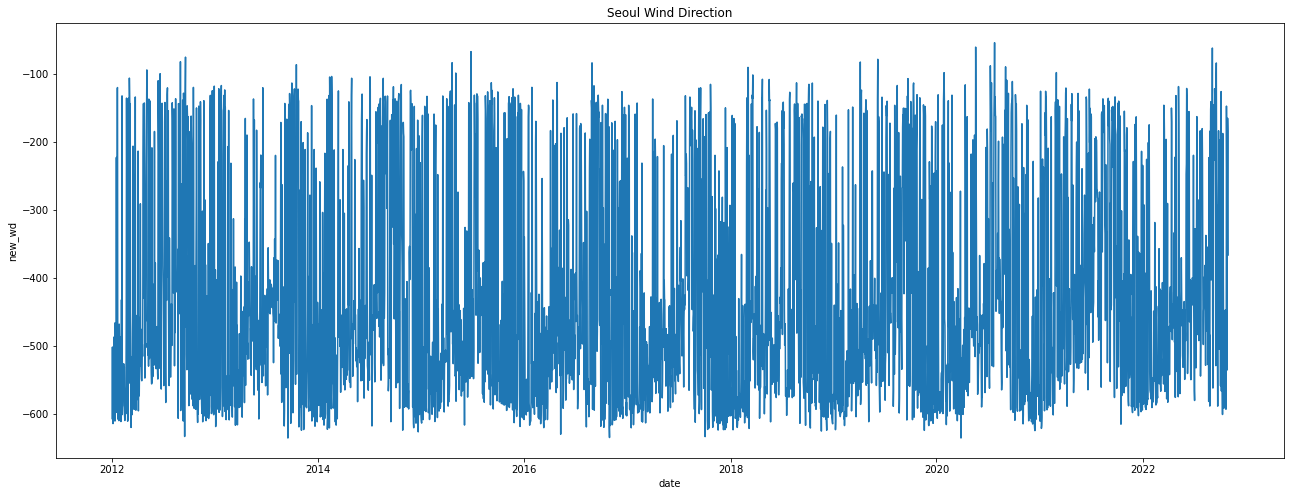

In [31]:
plt.figure(figsize=(22,8))
plt.plot(data1['date'], data1['new_wd'])
plt.title('Seoul Wind Direction')
plt.xlabel('date')
plt.ylabel('new_wd')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


<Figure size 432x288 with 0 Axes>

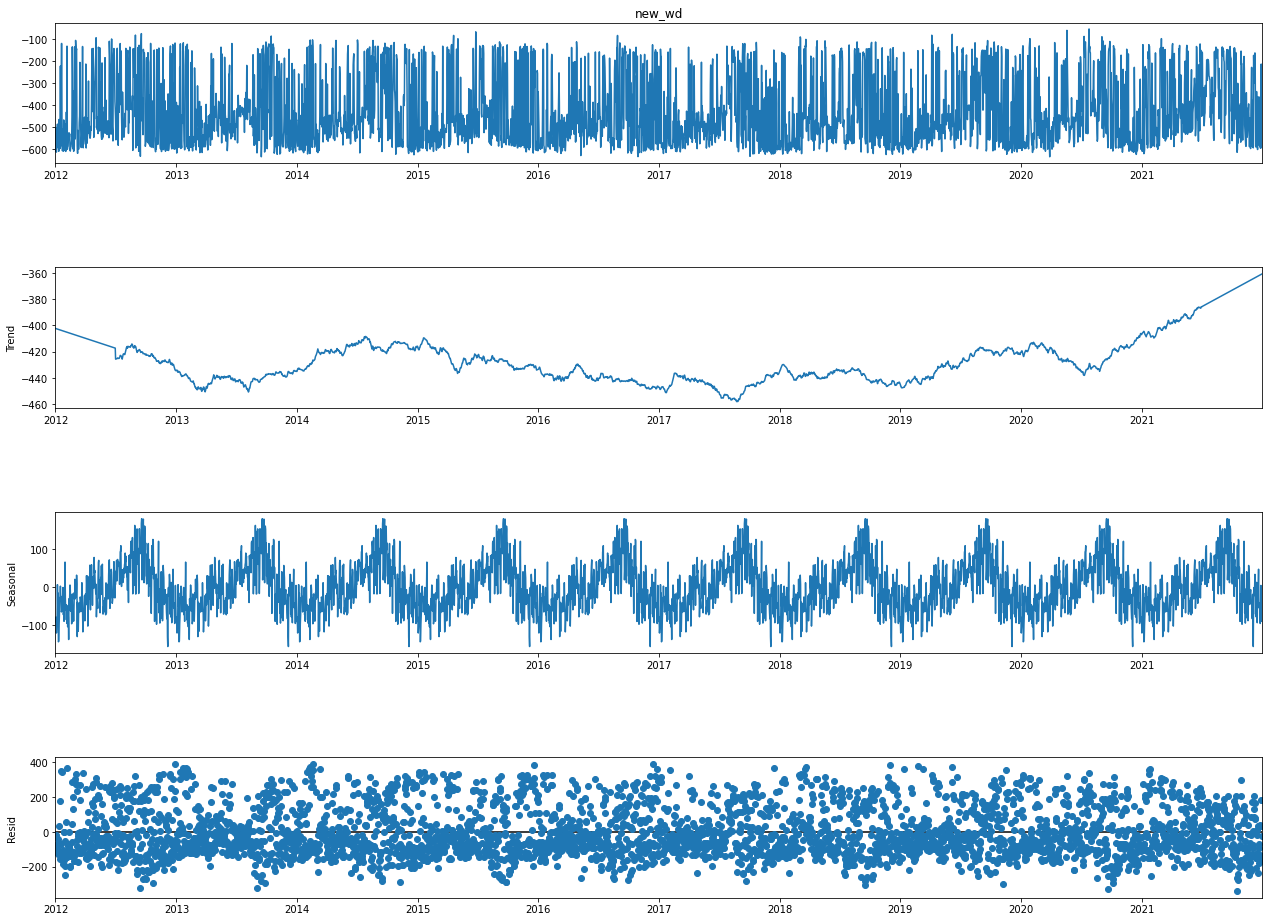

In [32]:
#시계열 분해법
train_ts = train.loc[:,['date', 'new_wd']]
train_ts.index = train_ts['date']
train_ts = train_ts.drop('date', axis = 1)
result = seasonal_decompose(train_ts['new_wd'], model = 'additive', freq = 365, extrapolate_trend=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

In [33]:
def tsplot(y, lags=None, figsize=(13, 8), style='bmh', title="Time Series Analysis Plots"):
    y = y.values
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    if not isinstance(title, str):
        title = str(title)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        _ = plt.xticks(np.arange(0, len(y), step=24))
        
        acf_ax = plt.subplot2grid(layout, (1, 0))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
 
    return plt.show()

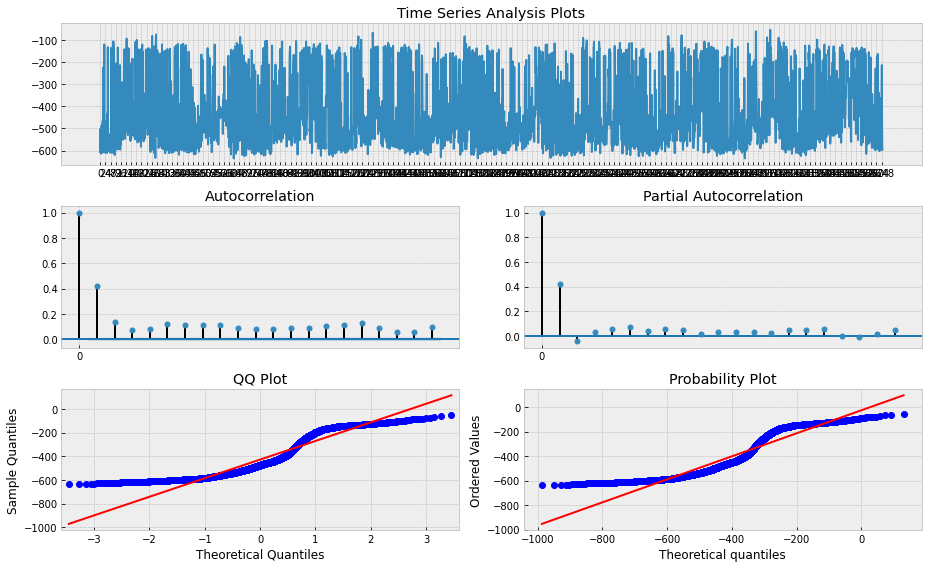

In [34]:
tsplot(train_ts['new_wd'], lags = 20)

In [35]:
#단위근 검정
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(train_ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.931239e+00
p-value                        3.508533e-12
#Lags Used                     2.200000e+01
Number of Observations Used    3.630000e+03
Critical Value (1%)           -3.432153e+00
Critical Value (5%)           -2.862337e+00
Critical Value (10%)          -2.567194e+00
dtype: float64


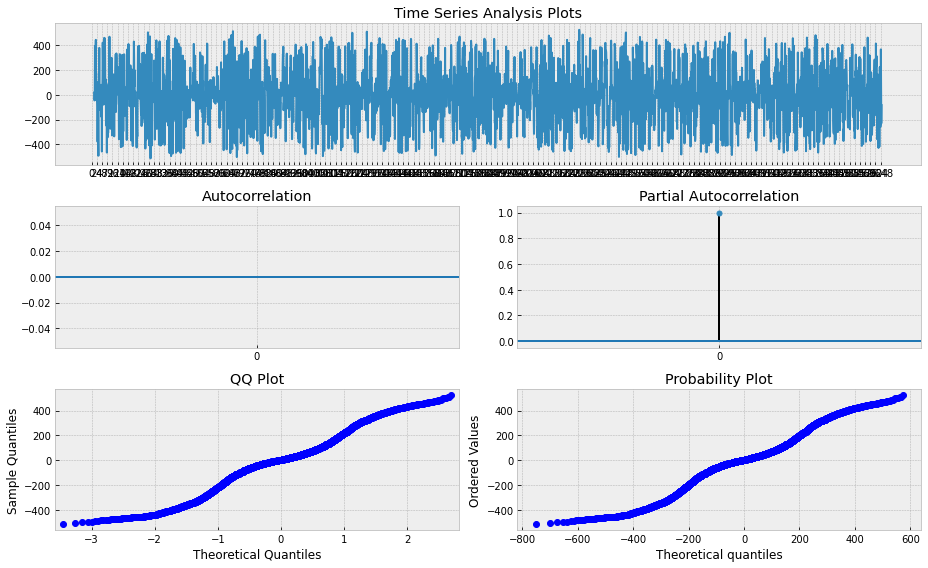

In [36]:
#계절성 제거
train_ts_diff = train_ts.diff(12)
tsplot(train_ts_diff['new_wd'], lags = 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

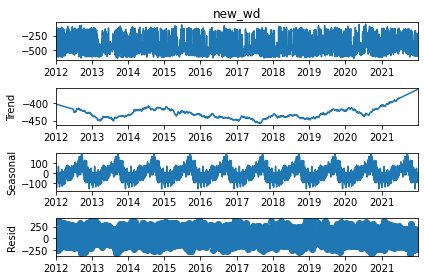

In [37]:
diff_result = seasonal_decompose(train_ts['new_wd'], model = 'additive', freq = 365, extrapolate_trend=365)
fig = plt.figure()
fig = diff_result.plot()

In [ ]:
## R로 auto arima##
#계절성 제거 arima(2,0,0)
#원래 arima(4,0,1)

In [39]:
raw_model = ARIMA(train_ts, order = (4,0,1))
raw_model_fit = raw_model.fit()
print(raw_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 new_wd   No. Observations:                 3653
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -23253.823
Date:                Tue, 15 Nov 2022   AIC                          46521.645
Time:                        05:53:28   BIC                          46565.068
Sample:                    01-01-2012   HQIC                         46537.109
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -428.2601     12.285    -34.861      0.000    -452.338    -404.182
ar.L1          1.3465      0.023     58.302      0.000       1.301       1.392
ar.L2         -0.4506      0.030    -15.205      0.0

In [41]:
diff_model = ARIMA(train_ts_diff, order = (2,0,0))
diff_model_fit = diff_model.fit()
print(diff_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 new_wd   No. Observations:                 3653
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -24394.360
Date:                Tue, 15 Nov 2022   AIC                          48796.719
Time:                        05:55:20   BIC                          48821.533
Sample:                    01-01-2012   HQIC                         48805.556
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2622      4.687      0.056      0.955      -8.925       9.449
ar.L1          0.3967      0.016     25.215      0.000       0.366       0.428
ar.L2         -0.0928      0.016     -5.736      0.0

In [43]:
prediction1 = raw_model_fit.forecast(365)
pred1_date = pd.date_range('2022-10-31', periods=365, freq='D')
pred1_date = pd.DataFrame(pred1_date)
prediction1 = pd.DataFrame(prediction1).reset_index(drop=True)
prediction1 = pd.concat([pred1_date, prediction1['predicted_mean']], axis = 1)

In [49]:
#계절성 제거
ts = data1.loc[:,['date', 'new_wd']]
ts.index = ts['date']
ts = ts.drop('date', axis = 1)
wd_ts_diff = ts.diff(12)
wd_ts_diff = wd_ts_diff.dropna()

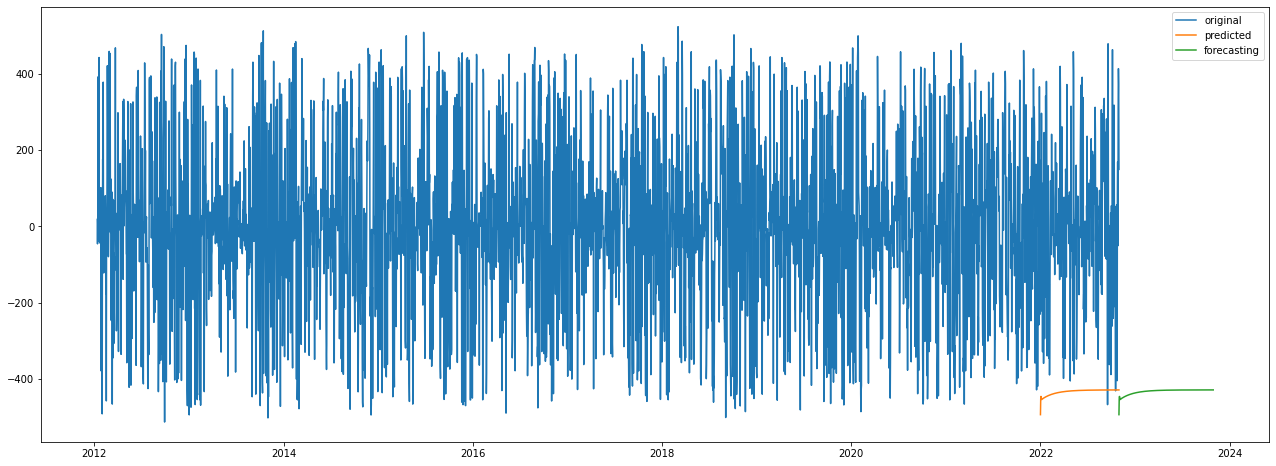

In [50]:
start_index = datetime(2022, 1, 1)
end_index = datetime(2022, 10, 31)

forecast = raw_model_fit.predict(start = start_index, end=end_index, typ='levels')

plt.figure(figsize = (22,8))
plt.plot(wd_ts_diff, label = 'original')
plt.plot(forecast, label = 'predicted')
plt.plot(prediction1[0], prediction1['predicted_mean'], label = 'forecasting')

plt.legend()
plt.show()

#**Holt Winters**

In [62]:
exp_fit = ExponentialSmoothing(train['new_wd'], trend = None,
                               seasonal = 'add', seasonal_periods = 365).fit()

print(exp_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


                       ExponentialSmoothing Model Results                       
Dep. Variable:                   new_wd   No. Observations:                 3653
Model:             ExponentialSmoothing   SSE                       95513456.566
Optimized:                         True   AIC                          37890.393
Trend:                             None   BIC                          40167.006
Seasonal:                      Additive   AICC                         37973.567
Seasonal Periods:                   365   Date:                 Tue, 15 Nov 2022
Box-Cox:                          False   Time:                         06:20:06
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.0257143                alpha                 True
smoothing_seasonal    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [63]:
prediction2 = exp_fit.forecast(365)

pred2_date = pd.date_range('2022-10-31', periods=365, freq='D')
pred2_date = pd.DataFrame(pred2_date)

prediction2 = pd.DataFrame(prediction2).reset_index(drop=True)

prediction2.rename(columns = {0:'new_wd'}, inplace = True)

prediction2 = pd.concat([pred2_date, prediction2['new_wd']], axis = 1)

prediction2.rename(columns = {0:'date'}, inplace = True)

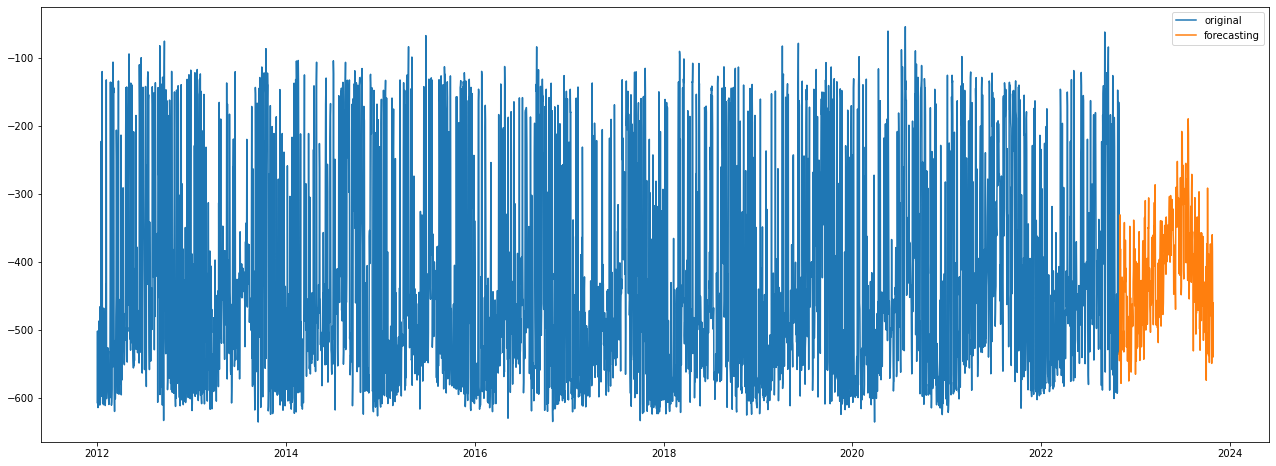

In [64]:
plt.figure(figsize = (22,8))
plt.plot(data1['date'], data1['new_wd'], label = 'original')
plt.plot(prediction2['date'], prediction2['new_wd'], label = 'forecasting')

plt.legend()
plt.show()

In [59]:
data2 = data1.copy()
data2['new_wd'] = -data1['new_wd']

In [60]:
train2 = data2.loc[data2.date <= '2021-12-31',:]
test2 = data2.loc[data2.date > '2021-12-31',:]
print(train2.shape, test2.shape)

(3653, 2) (304, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


<Figure size 432x288 with 0 Axes>

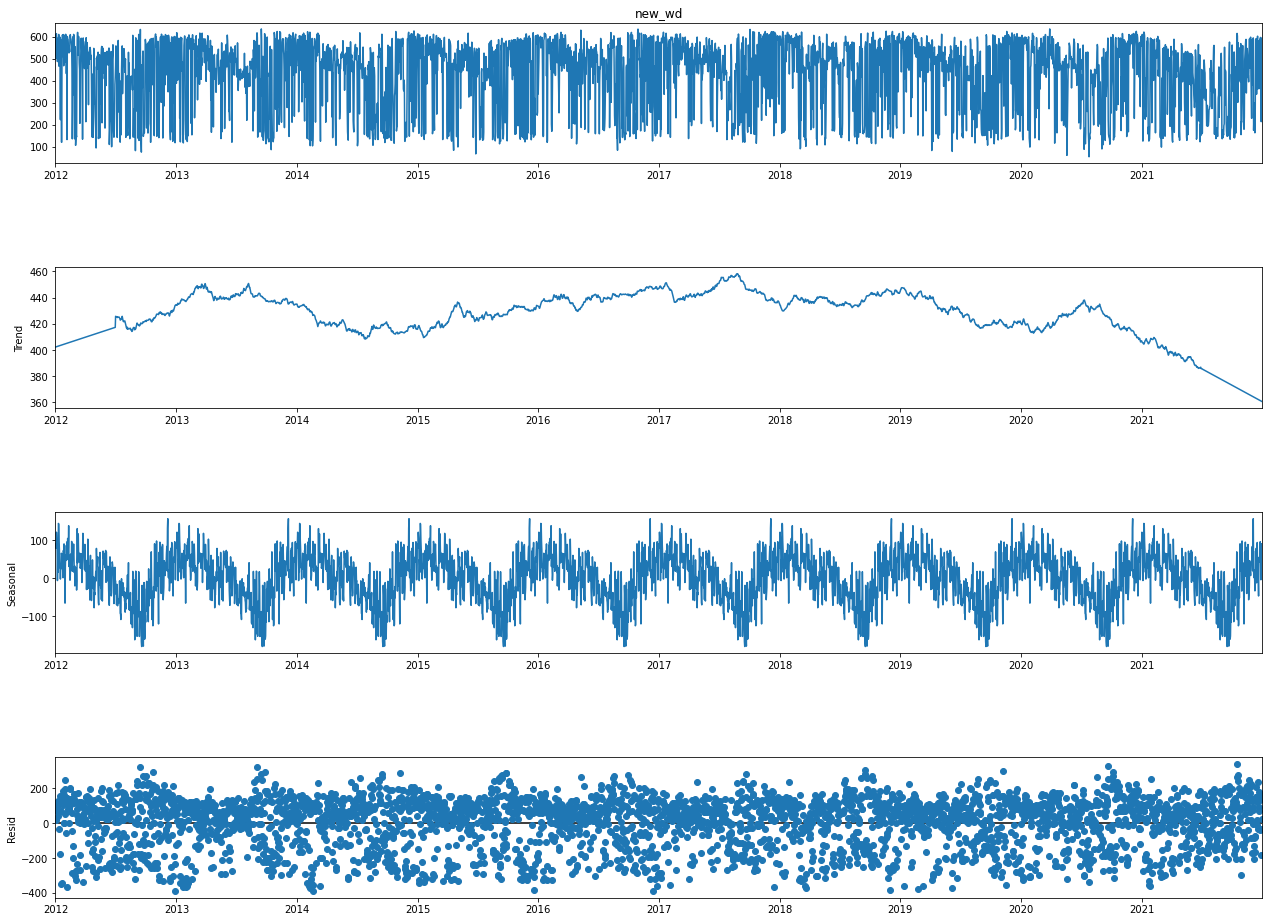

In [61]:
#시계열 분해법
train2_ts = train2.loc[:,['date', 'new_wd']]
train2_ts.index = train2_ts['date']
train2_ts = train2_ts.drop('date', axis = 1)
result = seasonal_decompose(train2_ts['new_wd'], model = 'additive', freq = 365, extrapolate_trend=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

In [74]:
np.log(train2_ts).diff()

,new_wd
date,
2012-01-01,NaN
2012-01-02,-0.190347
2012-01-03,0.191486
2012-01-04,0.010942
2012-01-05,-0.055172
...,...
2021-12-27,-0.615853
2021-12-28,-0.410504
2021-12-29,0.798921


In [65]:
log_train_ts = np.log(train2_ts+1) - np.mean(np.log(train2_ts+1))
log_train_ts

,new_wd
date,
2012-01-01,0.445563
2012-01-02,0.255562
2012-01-03,0.446701
2012-01-04,0.457624
2012-01-05,0.402545
...,...
2021-12-27,-0.185658
2021-12-28,-0.594592
2021-12-29,0.201764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

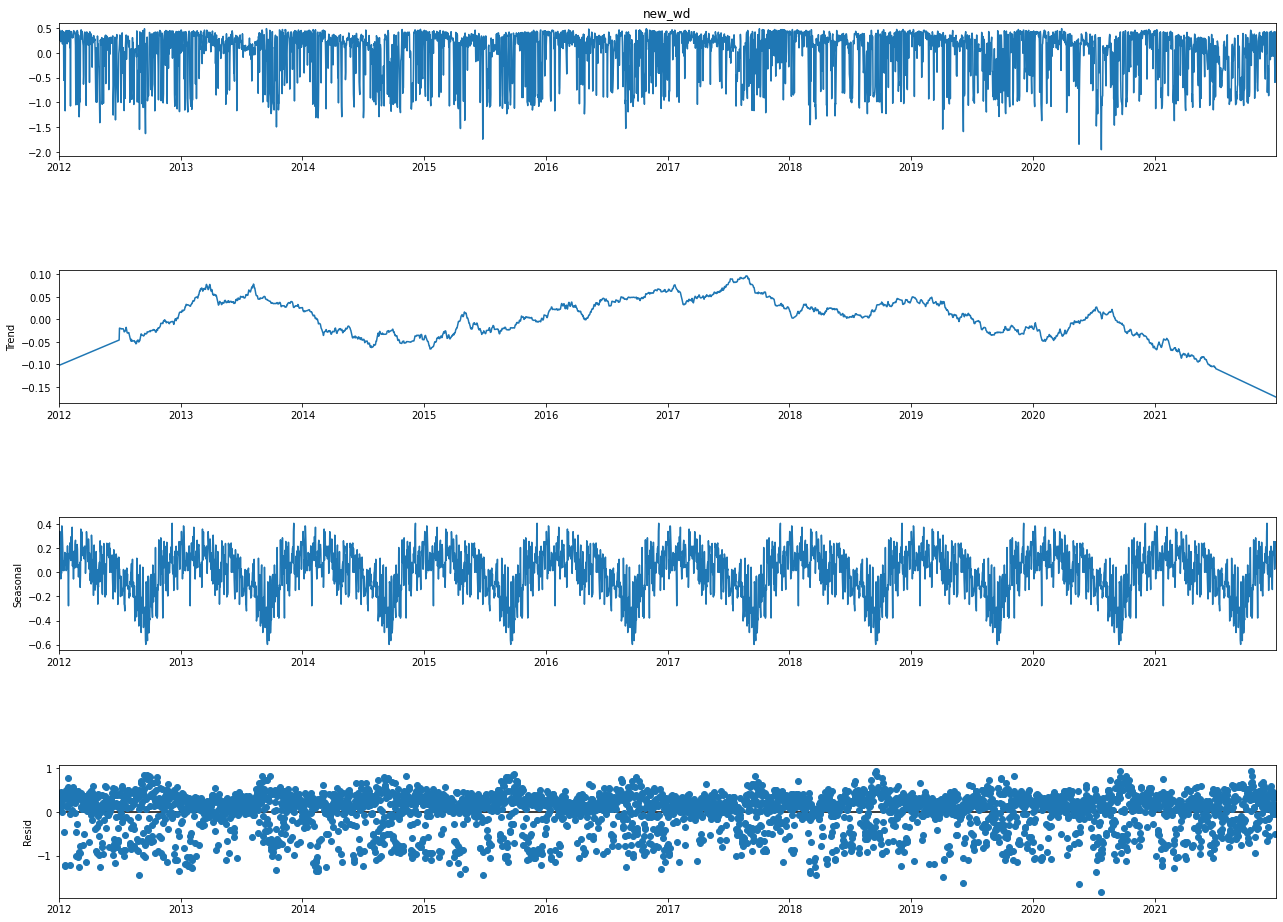

In [67]:
result = seasonal_decompose(log_train_ts['new_wd'], model = 'additive', freq = 365, extrapolate_trend=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

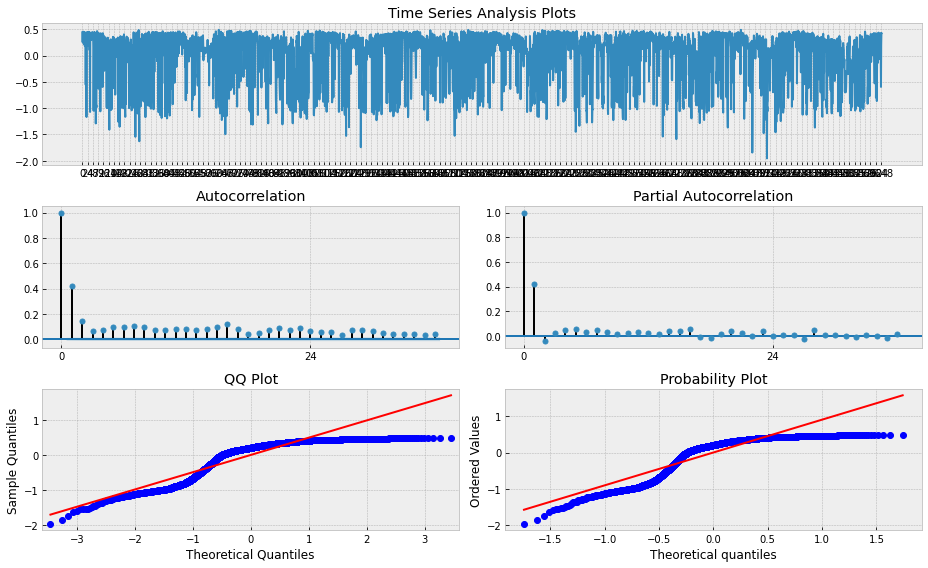

In [66]:
tsplot(log_train_ts['new_wd'])

In [69]:
log_wd_ts_diff = log_train_ts.diff(12)
log_wd_ts_diff = log_wd_ts_diff.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

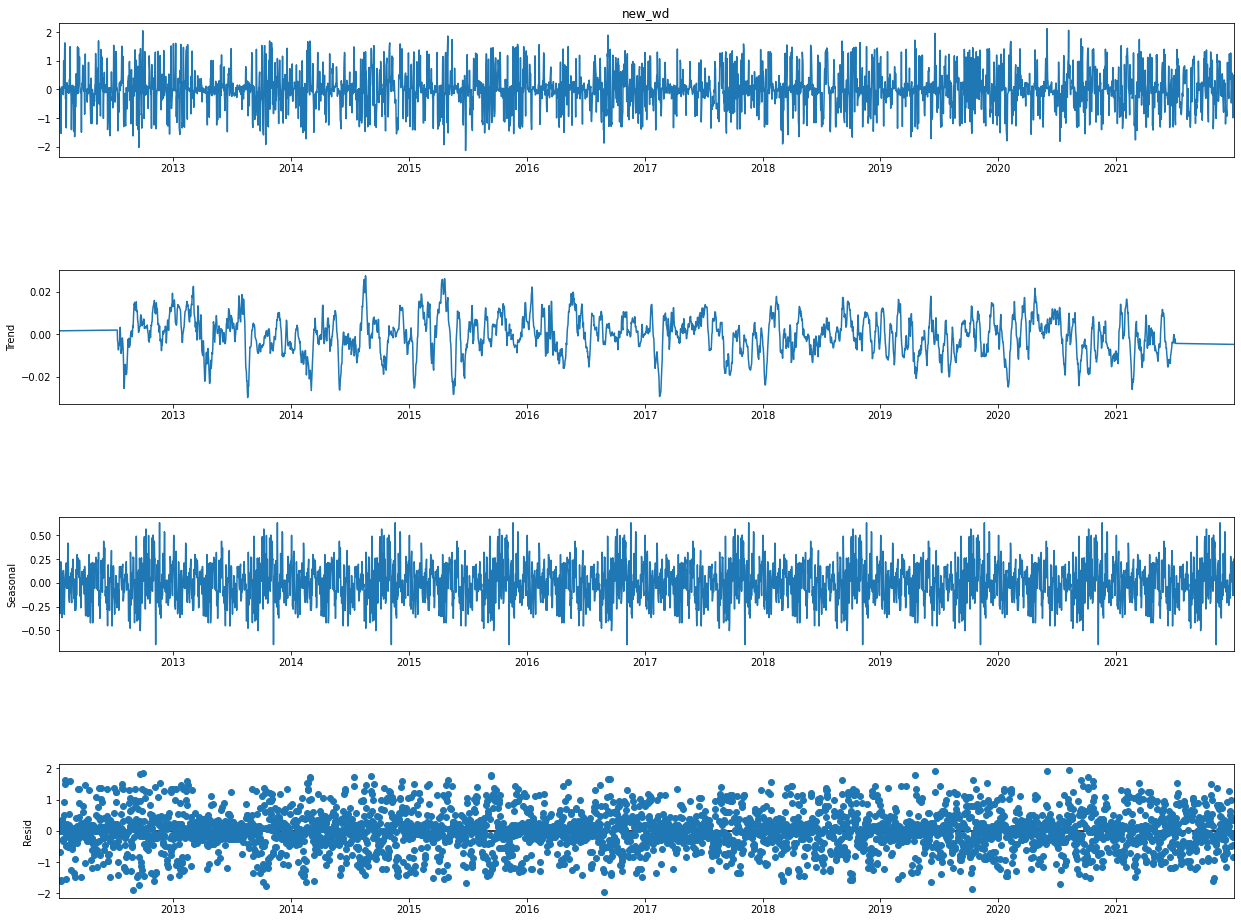

In [70]:
result = seasonal_decompose(log_wd_ts_diff['new_wd'], model = 'additive', freq = 365, extrapolate_trend=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

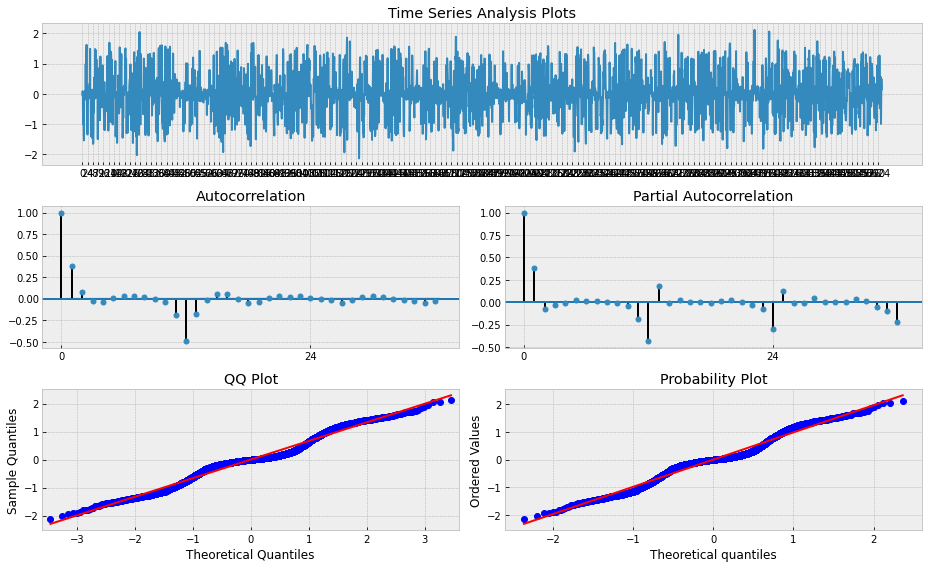

In [71]:
tsplot(log_wd_ts_diff['new_wd'])

In [72]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
'''
Simple Exponential Smoothing
>When to use?
Few data points, Irregular data, No seasonality or trend.
'''

In [91]:
exp_fit3 = ExponentialSmoothing(log_wd_ts_diff, trend = None,
                               seasonal = 'add', seasonal_periods = 365).fit()

print(exp_fit3.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


                       ExponentialSmoothing Model Results                       
Dep. Variable:                   new_wd   No. Observations:                 3641
Model:             ExponentialSmoothing   SSE                           1441.497
Optimized:                         True   AIC                          -2639.664
Trend:                             None   BIC                           -364.259
Seasonal:                      Additive   AICC                         -2556.185
Seasonal Periods:                   365   Date:                 Tue, 15 Nov 2022
Box-Cox:                          False   Time:                         06:41:40
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level               1.4901e-08                alpha                 True
smoothing_seasonal    

In [73]:
exp_fit2 = SimpleExpSmoothing(log_wd_ts_diff).fit()

print(exp_fit2.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                 new_wd   No. Observations:                 3641
Model:             SimpleExpSmoothing   SSE                           1610.303
Optimized:                       True   AIC                          -2966.459
Trend:                           None   BIC                          -2954.059
Seasonal:                        None   AICC                         -2966.448
Seasonal Periods:                None   Date:                 Tue, 15 Nov 2022
Box-Cox:                        False   Time:                         06:29:34
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level           1.4901e-08                alpha                 True
initial_level             -0.0006263                

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [93]:
prediction3 = exp_fit3.forecast(365)

pred3_date = pd.date_range('2022-10-31', periods=365, freq='D')
pred3_date = pd.DataFrame(pred3_date)

prediction3 = pd.DataFrame(prediction3).reset_index(drop=True)

prediction3.rename(columns = {0:'new_wd'}, inplace = True)

prediction3 = pd.concat([pred3_date, prediction3['new_wd']], axis = 1)

prediction3.rename(columns = {0:'date'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [86]:
prediction3

,date,new_wd
0,2022-10-31,0.498126
1,2022-11-01,0.177898
2,2022-11-02,0.032818
3,2022-11-03,-0.247546
4,2022-11-04,-0.085355
...,...,...
360,2023-10-26,-0.074985
361,2023-10-27,-0.135121
362,2023-10-28,0.224917
363,2023-10-29,0.145347


In [76]:
data_log = data2.copy()
data_log['new_wd'] = np.log(data2['new_wd']+1) - np.mean(np.log(data2['new_wd']+1))
data_log

,date,new_wd
0,2012-01-01,0.446209
1,2012-01-02,0.256207
2,2012-01-03,0.447346
3,2012-01-04,0.458270
4,2012-01-05,0.403190
...,...,...
3952,2022-10-27,0.321341
3953,2022-10-28,-0.310445
3954,2022-10-29,-0.850756
3955,2022-10-30,-0.737658


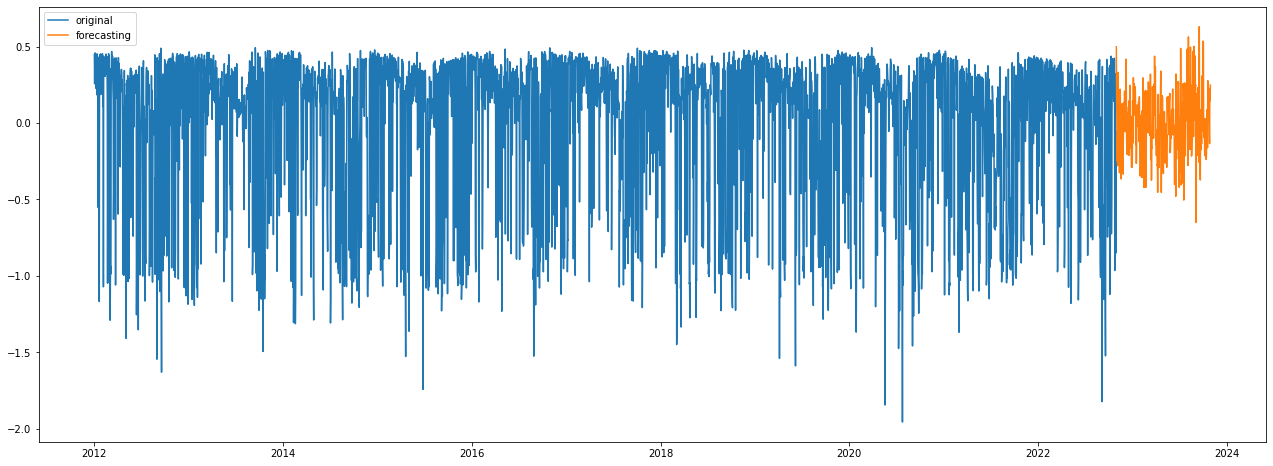

In [94]:
plt.figure(figsize = (22,8))
plt.plot(data_log['date'], data_log['new_wd'], label = 'original')
plt.plot(prediction3['date'], prediction3['new_wd'], label = 'forecasting')

plt.legend()
plt.show()